In [27]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as sci
import scipy.stats as scistats
from mcareader import Mca
import scipy.signal as fp
import os
import re

In [28]:
def extract_mca_data(file_path):
    data_values = []
    inside_data_section = False

    with open(file_path, 'r') as file:
        for line in file:
            line = line.strip()
            if line == "<<DATA>>":
                inside_data_section = True
                continue
            if line == "<<END>>":
                break
            if inside_data_section and line.isdigit():
                data_values.append(int(line))
    return data_values

In [29]:
channel_no=np.arange(1,len(E_spectrum_fe)+1)

In [30]:
E_spectrum_fe=extract_mca_data("team_battery/am_10_1790_spectrum.mca")
E_spectrum_am=extract_mca_data("team_battery/fe_10_1789_spectrum.mca")
E_spectrum_ba=extract_mca_data("team_battery/ba_10_1790_spectrum.mca")

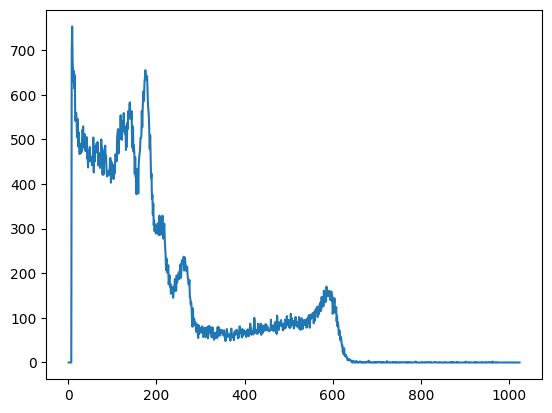

In [31]:
plt.plot(channel_no,E_spectrum_fe)

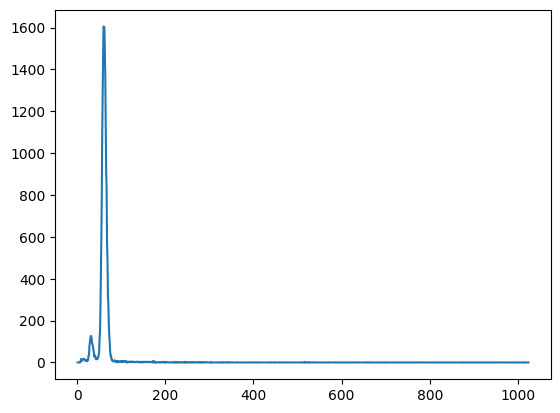

In [32]:
plt.plot(channel_no,E_spectrum_am)

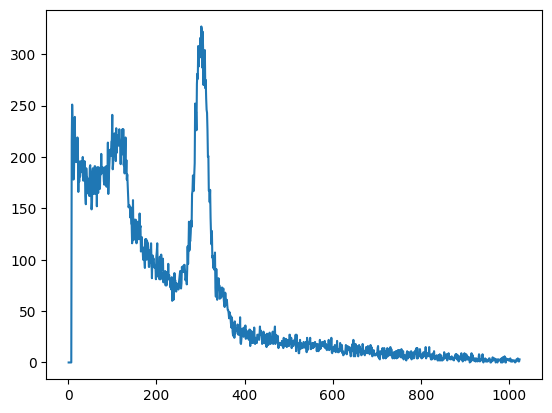

In [33]:
plt.plot(channel_no,E_spectrum_ba)